In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm
import sklearn

from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("mu_0.25/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)
N = coords.shape[0]

In [4]:
S = 1501

u_25 = lib.utils.read_data(S, N, 'mu_0.25/time_step_', 'vel_0')
u_25_train, u_25_test = sklearn.model_selection.train_test_split(u_25, test_size=0.1, random_state=42)

In [5]:
u_30 = lib.utils.read_data(S, N, 'mu_0.30/time_step_', 'vel_0')
u_30_train, u_30_test = sklearn.model_selection.train_test_split(u_30, test_size=0.1, random_state=42)

In [6]:
u_40 = lib.utils.read_data(S, N, 'mu_0.40/time_step_', 'vel_0')
u_40_train, u_40_test = sklearn.model_selection.train_test_split(u_40, test_size=0.1, random_state=42)

In [7]:
u_45 = lib.utils.read_data(S, N, 'mu_0.45/time_step_', 'vel_0')
u_45_train, u_45_test = sklearn.model_selection.train_test_split(u_45, test_size=0.1, random_state=42)

In [8]:
train_data = np.concatenate([u_25_train, u_30_train, u_40_train, u_45_train])
test_data = np.concatenate([u_25_test, u_30_test, u_40_test, u_45_test])

In [9]:
u_unseen = lib.utils.read_data(S, N, 'mu_0.35/time_step_', 'vel_0')

In [16]:
u_ref = np.mean(train_data, axis=0)

normalized_train_data = train_data - u_ref
normalized_test_data = test_data - u_ref
normalized_unseen_data = u_unseen - u_ref

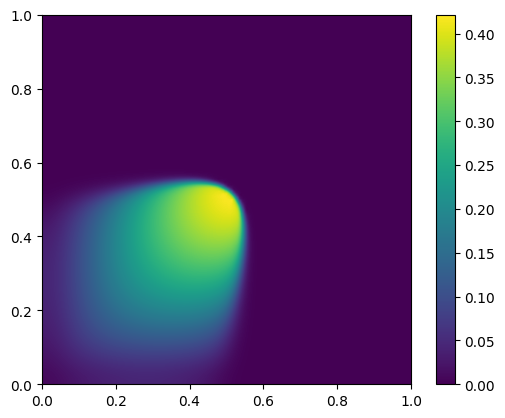

In [17]:
# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = train_data[5000].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,500)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

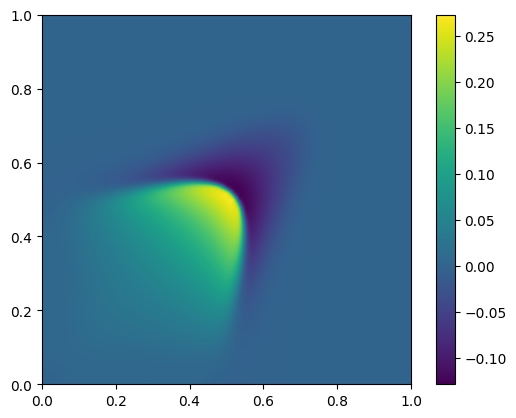

In [18]:
z = normalized_train_data[5000].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,500)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [19]:
m = 2000
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

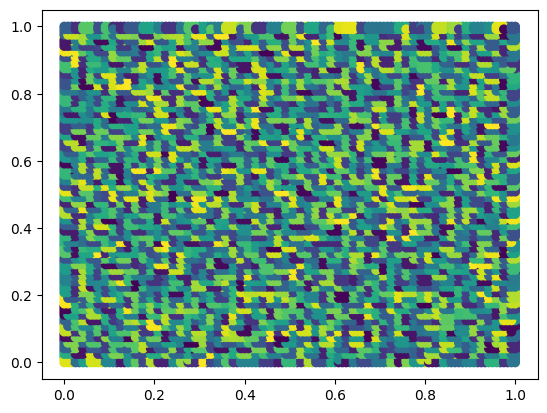

In [20]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

In [21]:
n = 20
# fixed support (length)
mu = int(np.ceil(N/200))
# mu = N
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [23]:
batch_size = 10
normalized_train_data = torch.tensor(normalized_train_data).to(device)
normalized_test_data = torch.tensor(normalized_test_data).to(device)
normalized_unseen_data = torch.tensor(normalized_unseen_data).to(device)

train_dataloader = DataLoader(normalized_train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(normalized_test_data, batch_size=batch_size, shuffle=True)
unseen_dataloader = DataLoader(normalized_unseen_data, batch_size=batch_size, shuffle=True)

In [24]:
ed = lib.nrbs_hot_map.EncoderDecoder(N=N, n=n, mu=mu, m=[200, m], B0=1.0/120, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [40]:
# ed.nrbs = torch.load('models/hotmap_0.005_60_60_200_200_N_100_m_1000_ref_vec_mu_0.30.pth')

In [22]:
ed.train(train_dataloader, test_dataloader, unseen_dataloader, comment="hotmap_5e-3_60_60_200_200_N_50_m_2000_mu_25", model_name = "models/hotmap_5e-3_60_60_200_200_N_50_m_2000_mu_25.pth", epochs=1000)

In [23]:
# ed.nrbs = torch.load("models/hotmap_5e-3_60_60_200_200_N_50_m_1000_mu_25.pth")

In [24]:
ed(u_25[500:501].to(device))[0].shape

torch.Size([14641])

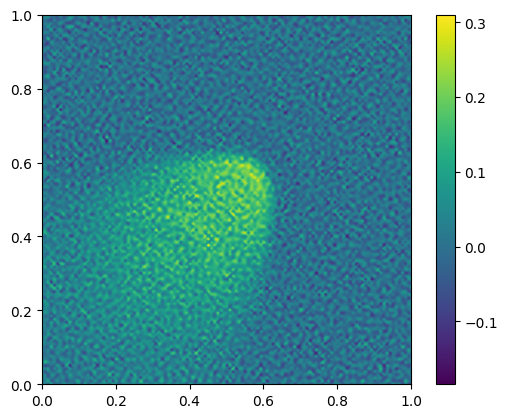

In [25]:
z = ed(u_25[1500:1501].to(device) - u_ref)[0]
z = z + u_ref
z = z.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [33]:
encoded = ed.nrbs.encode(train_dataloader.dataset[-1])
H = ed.nrbs.hotness(encoded)[ed.nrbs.clustering_labels]

bandwidths = ed.nrbs.bandwidths(encoded)

convolved_basis = ed.nrbs.convolve(ed.nrbs.decoder.weight.T, ed.nrbs.neighbour_id, ed.nrbs.neighbour_distance, bandwidths, ed.nrbs.mu)


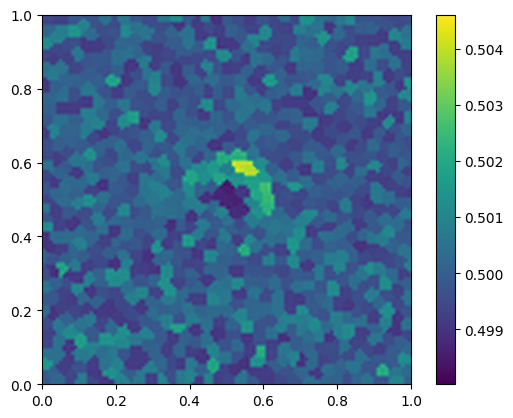

In [51]:
z = H.tolist()
# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()
# plt.show()

In [55]:
writer = SummaryWriter(comment='comment')
writer.add_image(tag='ms',img_tensor=zi,dataformats='HW')

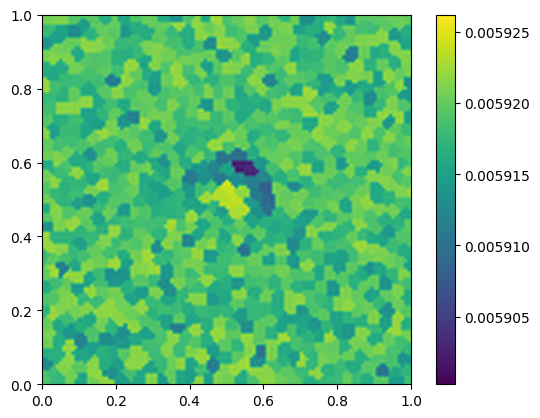

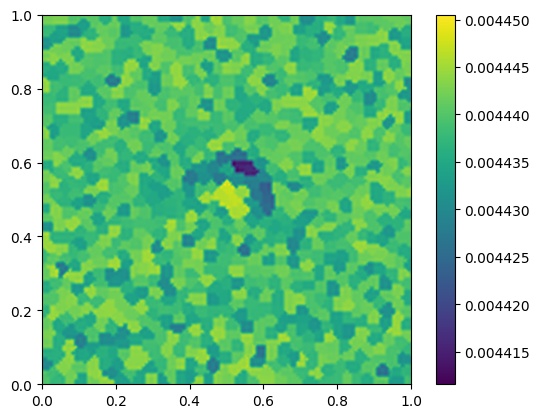

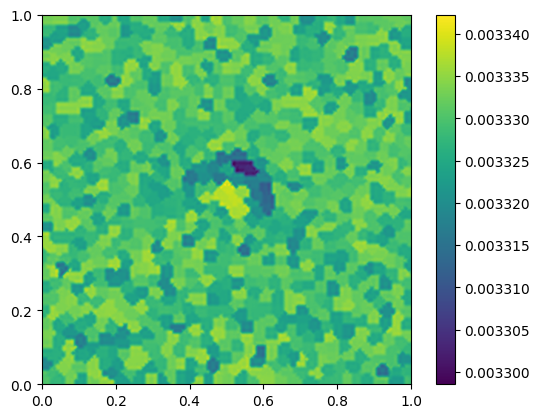

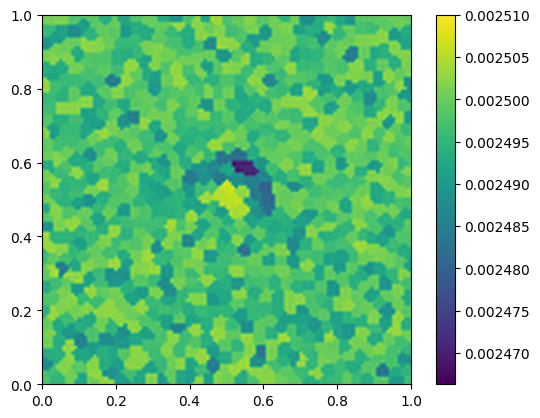

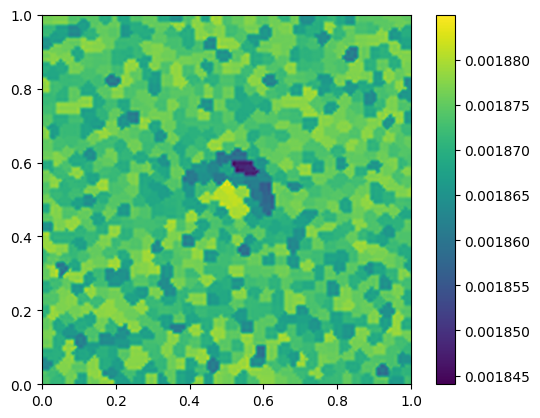

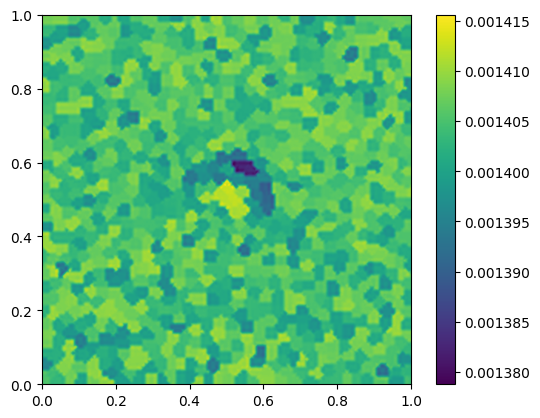

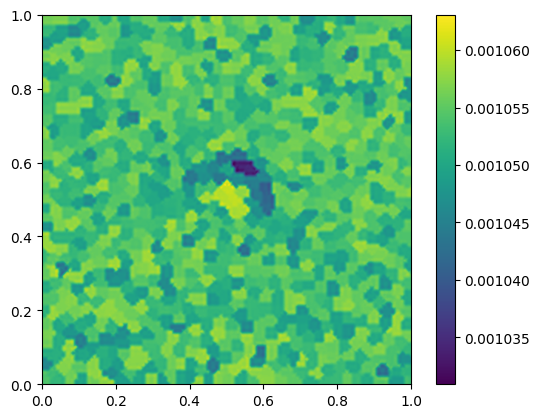

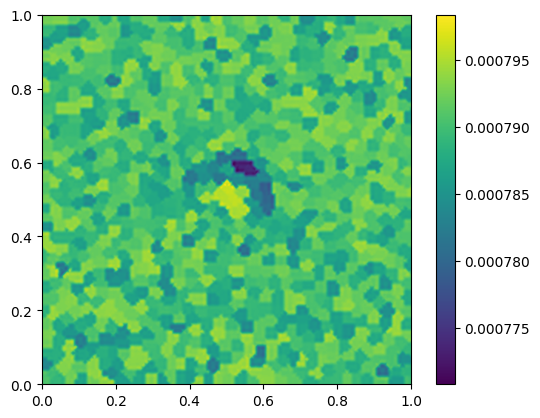

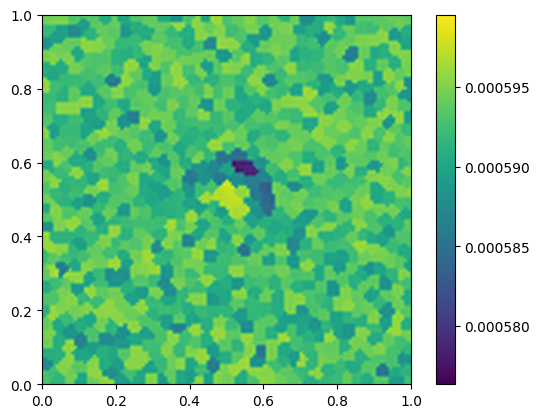

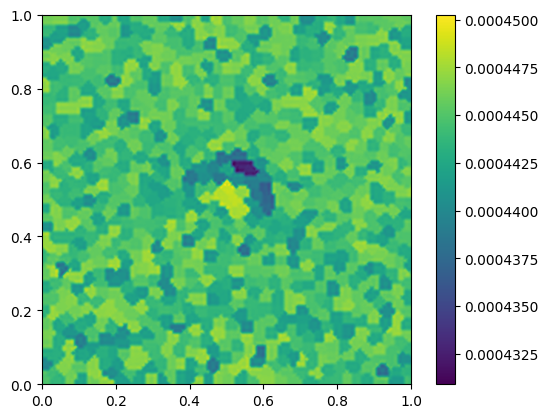

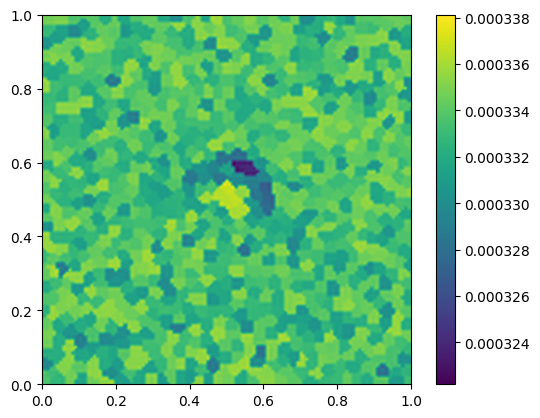

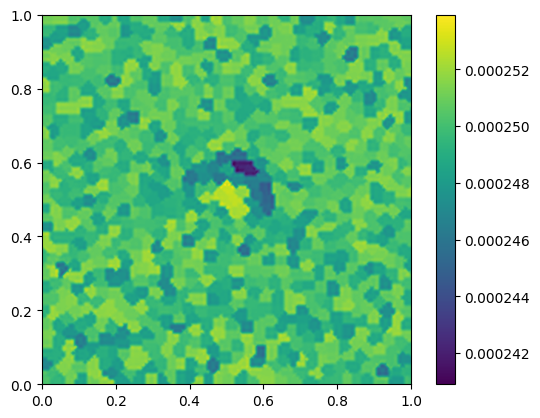

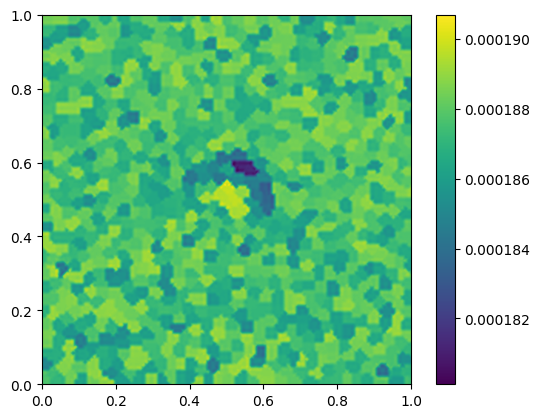

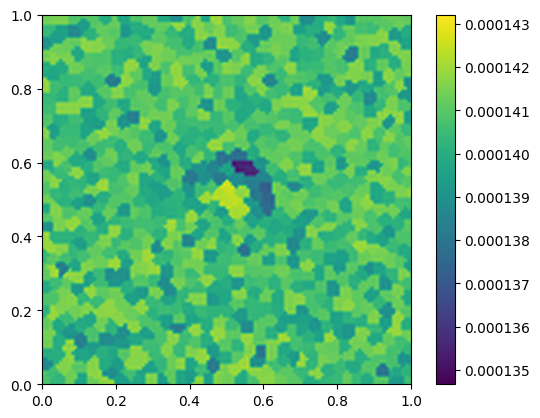

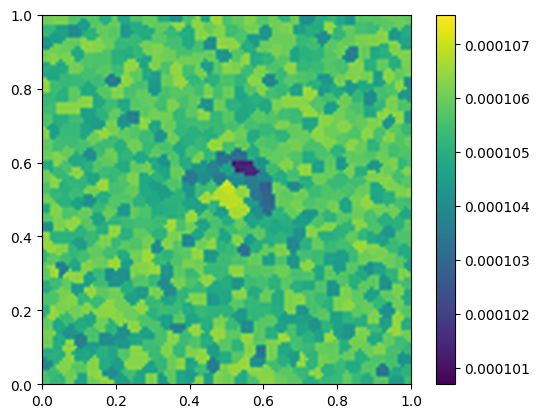

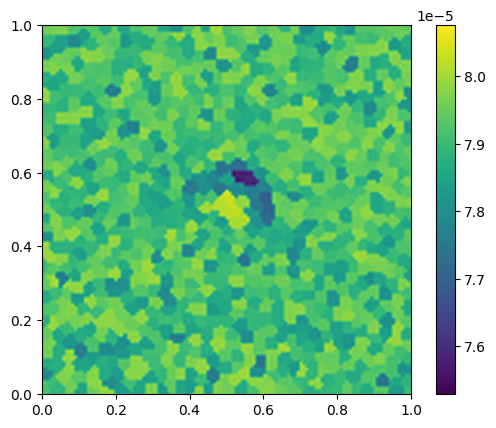

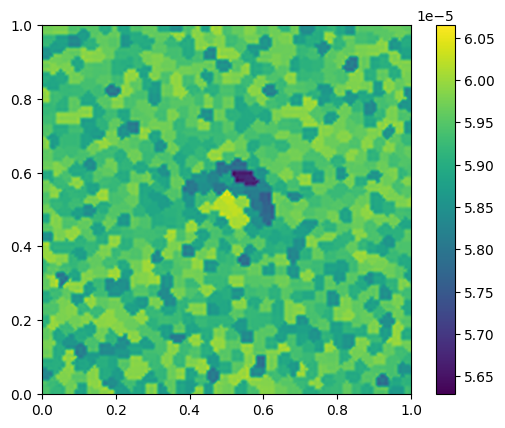

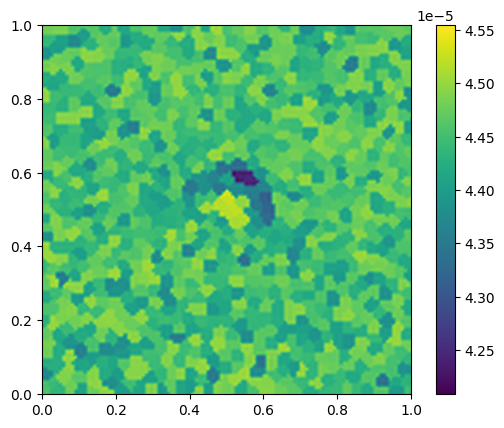

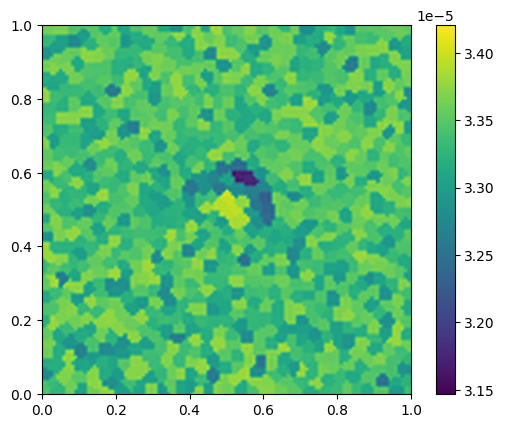

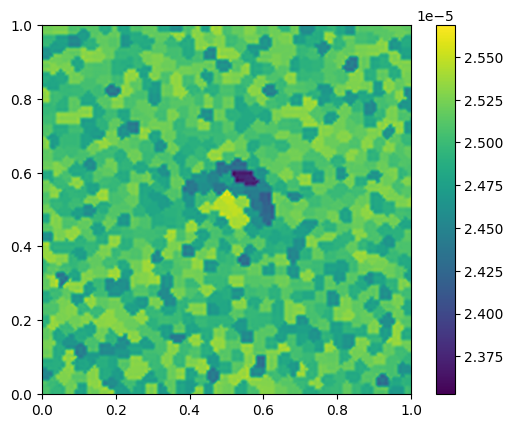

In [32]:
for i in range (bandwidths.shape[0]):
    z = bandwidths[i].tolist()

    # target grid to interpolate to
    xi = yi = np.linspace(0,1.0,1200)
    xi,yi = np.meshgrid(xi,yi)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='cubic')

    plt.imshow(zi,origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    plt.show()

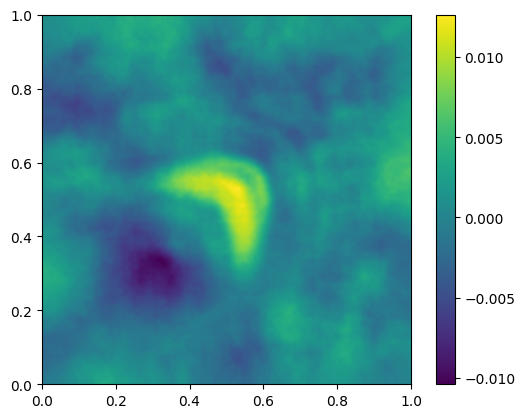

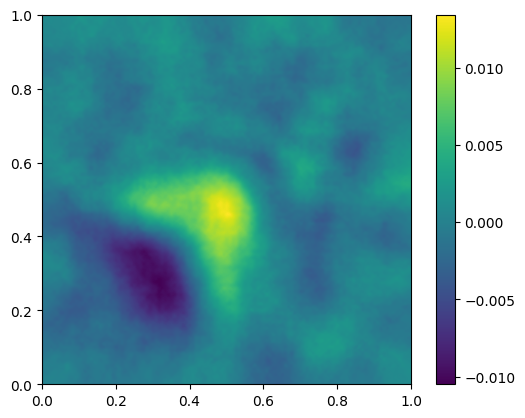

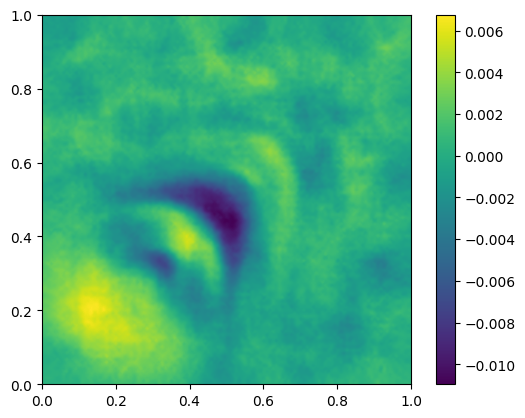

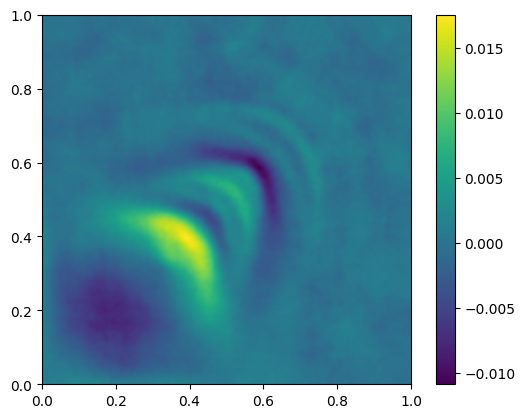

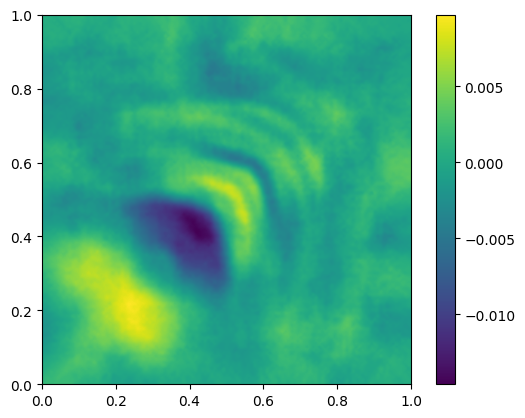

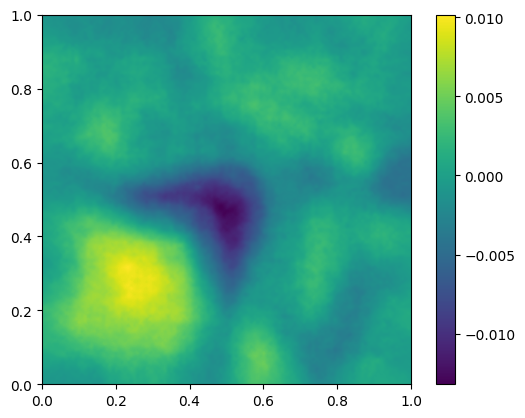

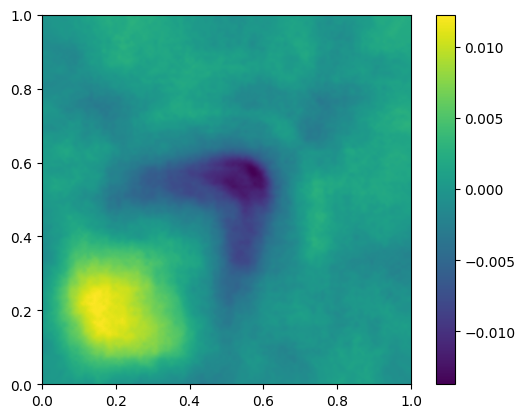

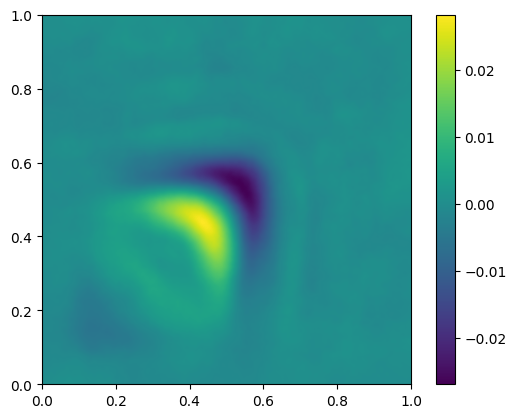

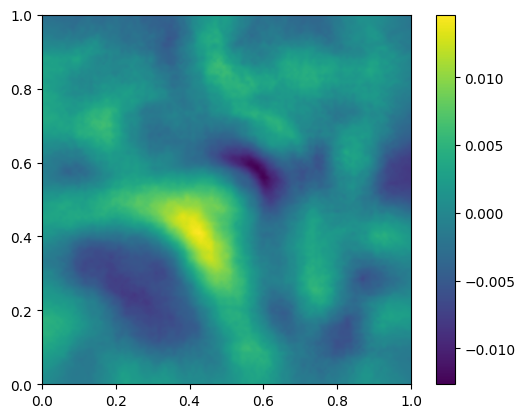

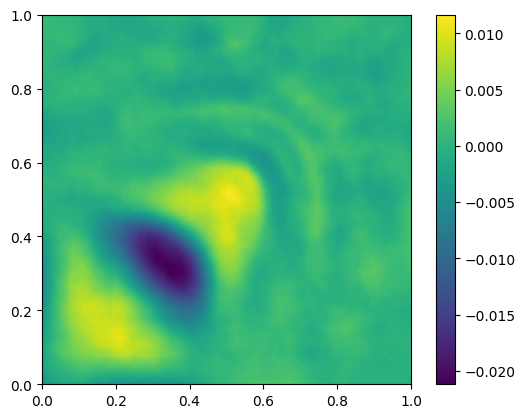

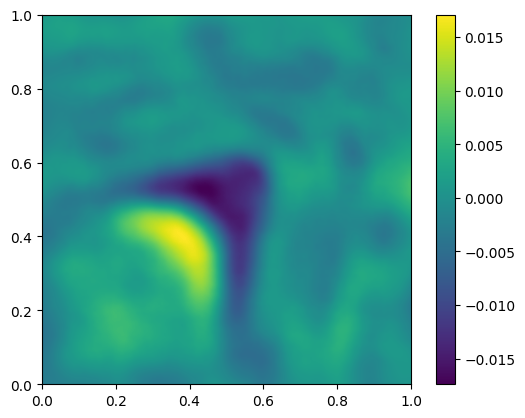

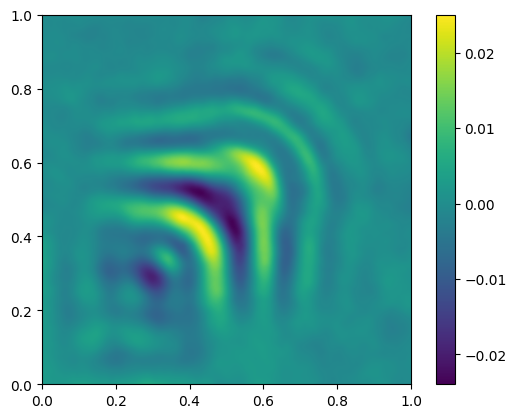

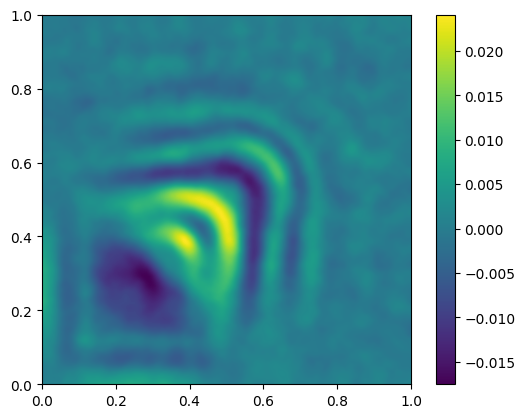

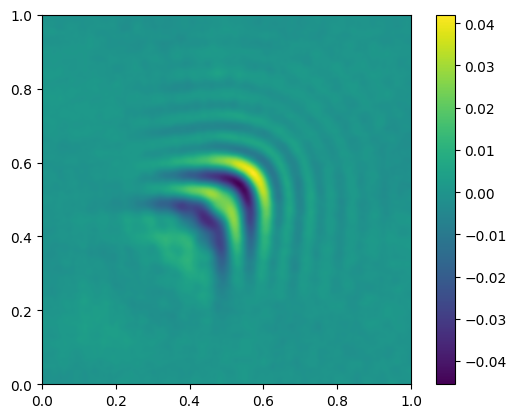

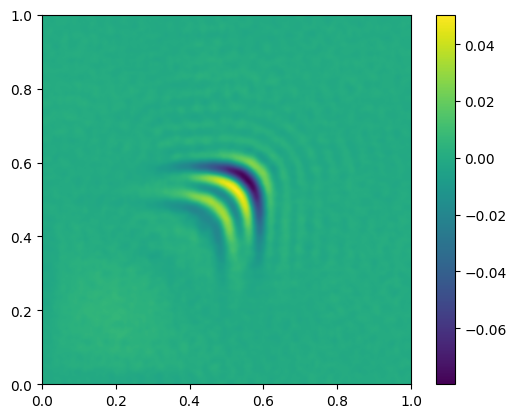

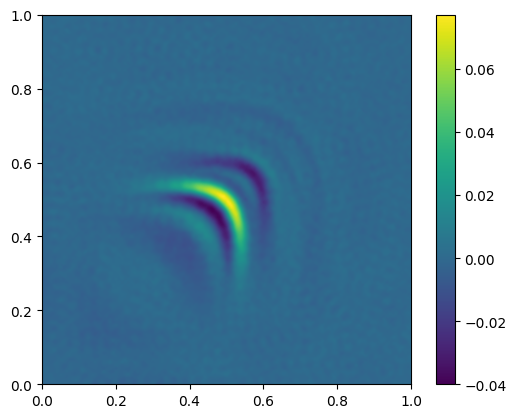

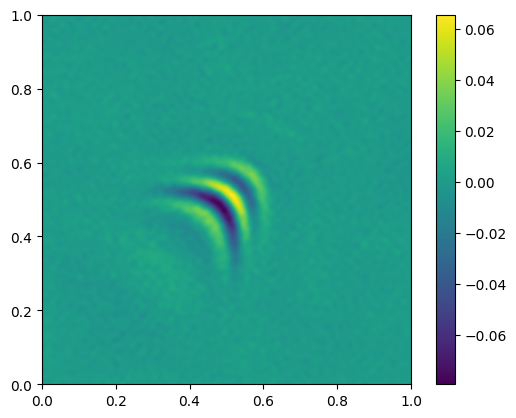

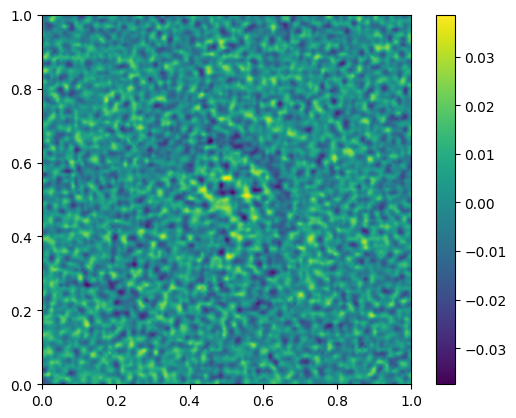

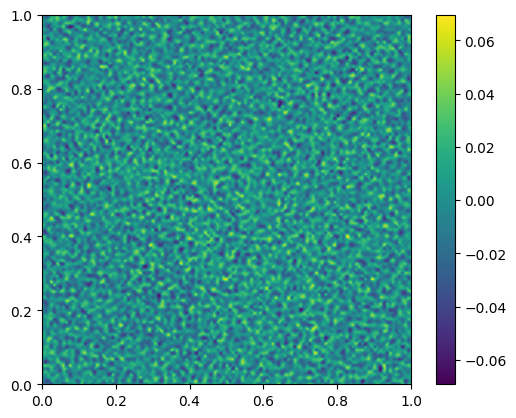

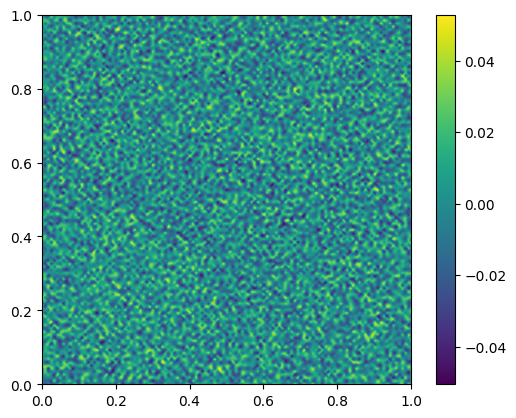

In [29]:
for i in range (convolved_basis.shape[0]):
    z = convolved_basis[i].tolist()

    # target grid to interpolate to
    xi = yi = np.linspace(0,1.0,1200)
    xi,yi = np.meshgrid(xi,yi)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='cubic')

    plt.imshow(zi,origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    plt.show()